In [61]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

DetectorFactory.seed = 42

 ## Начало анализа
 Первым делом хотелось бы понять как распределены отзывы по оценкам, также пока уберём инфу про название и описание фильмов

In [11]:
data_path = 'mustapp_reviews_total.csv'
extra_columns = ['Title', 'Description']

raw_must_dataset = pd.read_csv(data_path)
reviews_dataset = raw_must_dataset.drop(extra_columns, axis=1)
display(reviews_dataset)

,Mustapp page ID,Review text,Score (out of 10)
0,1,Фильм показывает нестабильную среду простых л...,8
1,1,Простые люди попадают в непростые обстоятельст...,8
2,2,В Финляндии более мрачные Патерсоны\n,7
3,2,Minimalistic with words but still full of mean...,8
4,2,"Просто, приземленно, обыденно, заурядно и имен...",8
...,...,...,...
177505,19992,jodete ledinapoporu te quiero \n,8
177506,19992,Todas las peliculas de doraemon son buenas lo ...,10
177507,19997,"It's good, but could be better...\n",7
177508,19997,Cute ‘95 chick flick. I love Whitney Houstonnn...,5


In [12]:
missing_values = reviews_dataset.isnull().sum()
duplicates = reviews_dataset.duplicated()

for col, count in missing_values.items():
  if count: print(f'В переменной {col} {count} пропущенных значений')
print(f'Всего дубликатов {duplicates.value_counts().iloc[1]}')

# df_train = reviews_dataset.drop_duplicates(subset=reviews_dataset.columns.difference(['selling_price']), keep='first')
reviews = reviews_dataset.drop_duplicates(keep='first')
reviews = reviews.reset_index(drop=True)
display(reviews.tail())

Всего дубликатов 529


,Mustapp page ID,Review text,Score (out of 10)
176976,19992,jodete ledinapoporu te quiero \n,8
176977,19992,Todas las peliculas de doraemon son buenas lo ...,10
176978,19997,"It's good, but could be better...\n",7
176979,19997,Cute ‘95 chick flick. I love Whitney Houstonnn...,5
176980,20000,1989\n,7


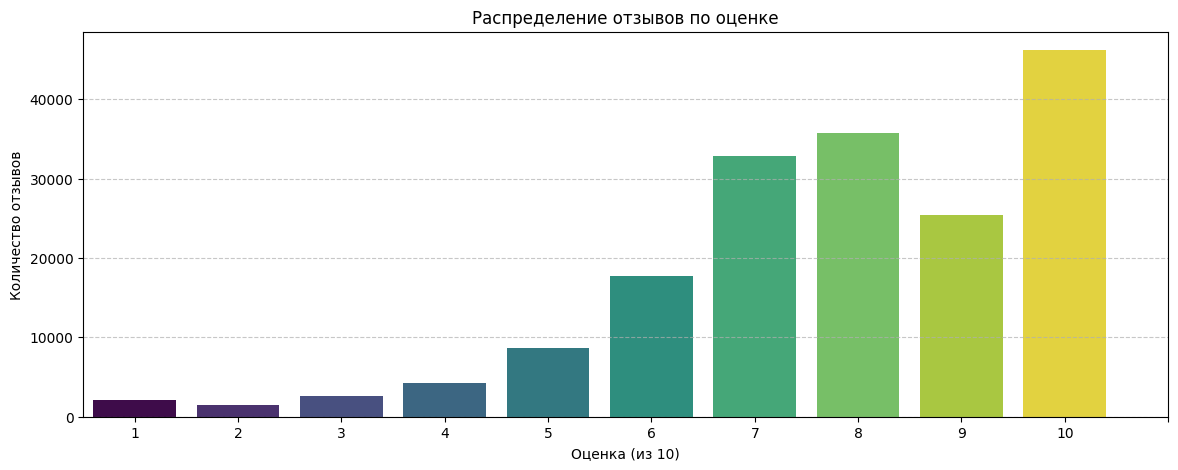

In [29]:
plt.figure(figsize=(14, 5))
sns.countplot(x=reviews['Score (out of 10)'], palette='viridis', hue=reviews['Score (out of 10)'], legend=False)
plt.title('Распределение отзывов по оценке')
plt.xlabel('Оценка (из 10)')
plt.ylabel('Количество отзывов')
plt.xticks(range(0, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Хотелось бы избавиться от сильного выброса положительных отзывов

Наш коллега Даня уже прекрасно справился с этой проблемой путём выбора сабсета положительных отзывов, но я пока воздержусь и буду анализировать весь датасет, так как пока непонятно с какими языками мы будем работать

Аналогично вышеупомянутому мужчине, мы посмотрим на взаимосвязь длины отзыва и оценки

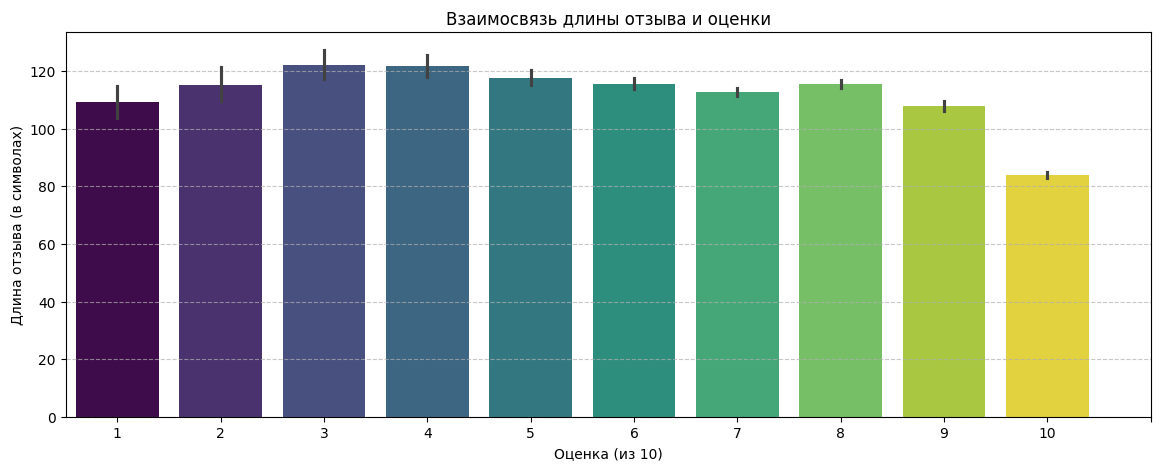

In [30]:
reviews['Review length'] = reviews['Review text'].apply(len)

plt.figure(figsize=(14, 5))
sns.barplot(x=reviews['Score (out of 10)'], y=reviews['Review length'], palette='viridis', hue=reviews['Score (out of 10)'], legend=False)
plt.title('Взаимосвязь длины отзыва и оценки')
plt.xlabel('Оценка (из 10)')
plt.ylabel('Длина отзыва (в символах)')
plt.xticks(range(0, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Как и ожидалось, в среднем отрицательные отзывы будут побольше

Давайте временно решим языковую проблему не самым умным, но статистически полезным образом – добавим в датасет колонку с количеством русских букв в отзыве и построим график, чтобы посмотреть, в скольких отзывах встречается хотя бы одна русская буква

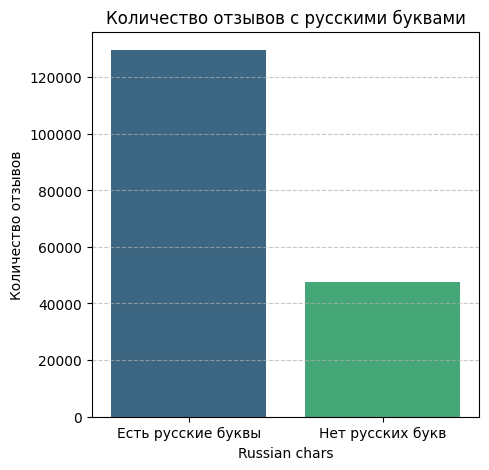

In [55]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

reviews['Russian chars'] = reviews['Review text'].apply(count_russian_chars)

reviews_russian = reviews['Russian chars'] > 0
counts = reviews_russian.value_counts()

# display(counts)

plt.figure(figsize=(5, 5))
sns.barplot(x=counts.index.astype(str), y=counts.values, palette='viridis', hue=counts.index.astype(str), legend=False)
plt.xticks(ticks=[0, 1], labels=['Есть русские буквы', 'Нет русских букв'])
plt.ylabel('Количество отзывов')
plt.title('Количество отзывов с русскими буквами')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Нормально так богатыри захватили must заморский

Мы упоминали, что может быть будущая модель будет давать бинарный результат — давайте на это тоже посмотрим, выкинем оценки 5-6, кажется, без них всё точно логично поделится

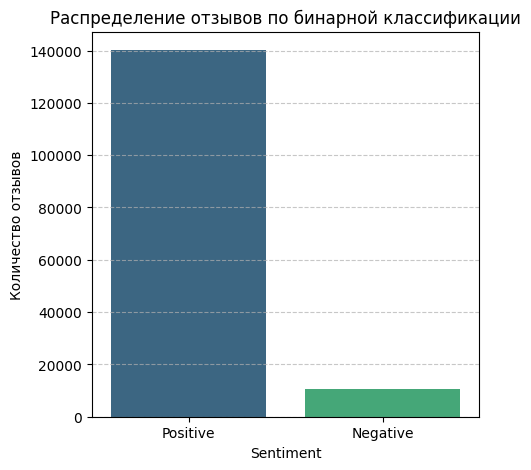

In [59]:
reviews['Sentiment'] = reviews['Score (out of 10)'].apply(lambda x: 'Positive' if x >= 7 else ('Negative' if x <= 4 else None))
reviews_bin = reviews.dropna(subset=['Sentiment'])
sentiment_counts = reviews_bin['Sentiment'].value_counts()

# display(sentiment_counts)

plt.figure(figsize=(5, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis', hue=sentiment_counts.index, legend=False)
plt.ylabel('Количество отзывов')
plt.title('Распределение отзывов по бинарной классификации')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Похоже в будущем чистить и балансировать датасет мы будем довольно смело

## Языковой барьер
Мы умеем гуглить и пользоваться гпт, поэтому знаем, что с помощью модуля `langdetect` без проблем определим языки отзывов, хоть это и не детерминированное решение, но зато хорошо работает на небольших текстах (по словам разраба), короткие отзывы могут показывать странные результаты, но мы их потом всё равно выкинем во время препроцессинга

In [ ]:
# ЯДЕРКА НА 11 МИНУТ
def detect_language(s):
    try:
        return detect(s)
    except LangDetectException:
        return 'Unknown'
    
reviews['Language'] = reviews['Review text'].apply(detect_language)

Language
ru         115210
en          20214
Unknown      9476
uk           5120
es           4620
mk           4384
bg           4338
it           3674
fr           1909
pt            677
ro            554
ca            540
de            534
af            486
cy            477
ja            471
so            404
tr            347
th            346
nl            321
tl            290
fa            267
id            259
no            197
ar            192
et            189
sv            176
sk            174
da            165
sl            162
pl            154
hr            119
sw            109
fi             76
hu             57
sq             57
vi             51
cs             42
lt             38
zh-cn          37
lv             23
ko             20
ur             14
el              6
ta              3
kn              1
zh-tw           1
Name: count, dtype: int64

Выкинем все неизвестные и посмотрим на топ 10

In [68]:
reviews_lang = reviews[reviews['Language'] != 'Unknown']
reviews_lang = reviews_lang.reset_index(drop=True)
language_counts = reviews_lang['Language'].value_counts()

display(reviews_lang)
display(language_counts)

,Mustapp page ID,Review text,Score (out of 10),Review length,Russian chars,Sentiment,Language
0,1,Фильм показывает нестабильную среду простых л...,8,182,146,Positive,ru
1,1,Простые люди попадают в непростые обстоятельст...,8,235,189,Positive,ru
2,2,В Финляндии более мрачные Патерсоны\n,7,44,31,Positive,ru
3,2,Minimalistic with words but still full of mean...,8,96,0,Positive,en
4,2,"Просто, приземленно, обыденно, заурядно и имен...",8,127,97,Positive,ru
...,...,...,...,...,...,...,...
167500,19980,Réaliste \n,10,18,0,Positive,fr
167501,19992,jodete ledinapoporu te quiero \n,8,39,0,Positive,es
167502,19992,Todas las peliculas de doraemon son buenas lo ...,10,61,0,Positive,es
167503,19997,"It's good, but could be better...\n",7,42,0,Positive,en


Language
ru       115210
en        20214
uk         5120
es         4620
mk         4384
bg         4338
it         3674
fr         1909
pt          677
ro          554
ca          540
de          534
af          486
cy          477
ja          471
so          404
tr          347
th          346
nl          321
tl          290
fa          267
id          259
no          197
ar          192
et          189
sv          176
sk          174
da          165
sl          162
pl          154
hr          119
sw          109
fi           76
hu           57
sq           57
vi           51
cs           42
lt           38
zh-cn        37
lv           23
ko           20
ur           14
el            6
ta            3
kn            1
zh-tw         1
Name: count, dtype: int64

In [69]:
top = 10
if len(language_counts) > top:
    other_count = language_counts.iloc[top:].sum()
    language_counts = language_counts.iloc[:top]
    language_counts['other'] = other_count

display(language_counts)

Language
ru       115210
en        20214
uk         5120
es         4620
mk         4384
bg         4338
it         3674
fr         1909
pt          677
ro          554
other      6805
Name: count, dtype: int64

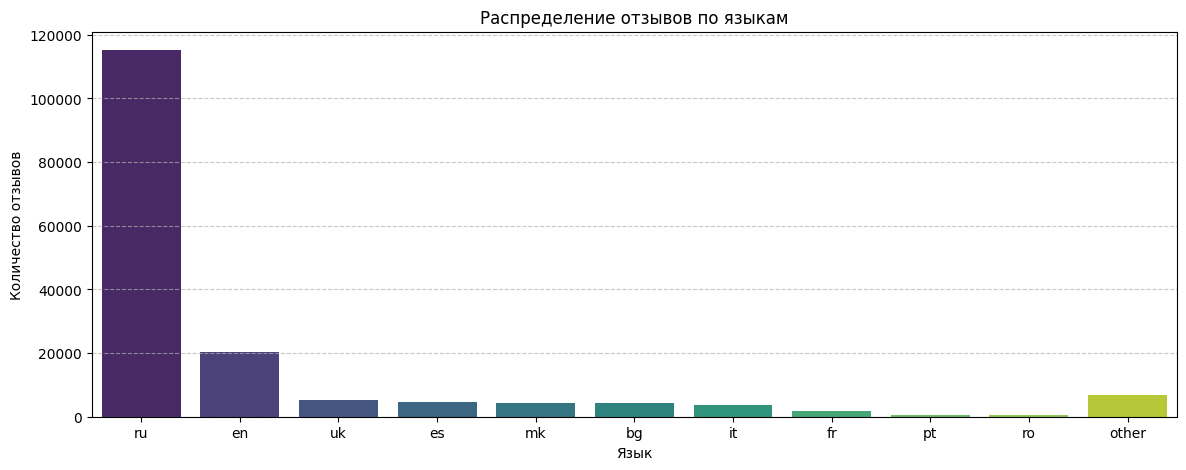

In [72]:
plt.figure(figsize=(14, 5))
sns.barplot(x=language_counts.index, y=language_counts.values, palette='viridis', hue=language_counts.index, legend=False)
plt.xlabel('Язык')
plt.ylabel('Количество отзывов')
plt.title('Распределение отзывов по языкам')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ну как-то очевидно

А что если посмотреть на среднюю/медиану оценки для каждого языка?

In [94]:
lang_stats = reviews_lang.groupby('Language')['Score (out of 10)'].agg(['mean', 'median', 'std', 'count'])

lang_stats_filtered = lang_stats[lang_stats['count'] >= language_counts[top-1]]
# lang_stats_filtered = lang_stats[lang_stats['count'] >= 100]

display(lang_stats_filtered)

/var/folders/jm/7zgk4hp93jgb153vvqrrshrm0000gn/T/ipykernel_14953/3325517904.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lang_stats_filtered = lang_stats[lang_stats['count'] >= language_counts[top-1]]


,mean,median,std,count
Language,,,,
bg,7.778008,8.0,2.123641,4338
en,7.886465,8.0,1.889471,20214
es,7.729437,8.0,1.683034,4620
fr,7.544788,8.0,1.991257,1909
it,7.675014,8.0,1.823999,3674
mk,7.708942,8.0,2.212971,4384
pt,8.268833,9.0,1.933461,677
ro,8.803249,9.0,1.576015,554
ru,7.807942,8.0,1.968759,115210


Не впечатлило, кажется, пришло время брать сабсет данных

Теперь это делать можно смело, так как русских отзывов уж слишком много, ничего не мешает потерять какую-то их часть (конечно, в будущем мы сначала будем выкидывать что-то маленькое по размерам, а уже после думать про всякие сабсеты, но пока пусть будет так)

In [95]:
reviews_lang_10 = reviews_lang[reviews_lang['Score (out of 10)'] == 10].sample(n=3000, random_state=42)
reviews_lang_9 = reviews_lang[reviews_lang['Score (out of 10)'] == 9].sample(n=3000, random_state=42)
reviews_lang_8 = reviews_lang[reviews_lang['Score (out of 10)'] == 8].sample(n=3000, random_state=42)
reviews_lang_7 = reviews_lang[reviews_lang['Score (out of 10)'] == 7].sample(n=3000, random_state=42)
reviews_lang_6 = reviews_lang[reviews_lang['Score (out of 10)'] == 6].sample(n=3000, random_state=42)
reviews_lang_5 = reviews_lang[reviews_lang['Score (out of 10)'] == 5].sample(n=3000, random_state=42)
reviews_lang_others = reviews_lang[reviews_lang['Score (out of 10)'] < 5]
reviews_balanced = pd.concat([reviews_lang_others, reviews_lang_5, reviews_lang_6, reviews_lang_7, reviews_lang_8, reviews_lang_9, reviews_lang_10])

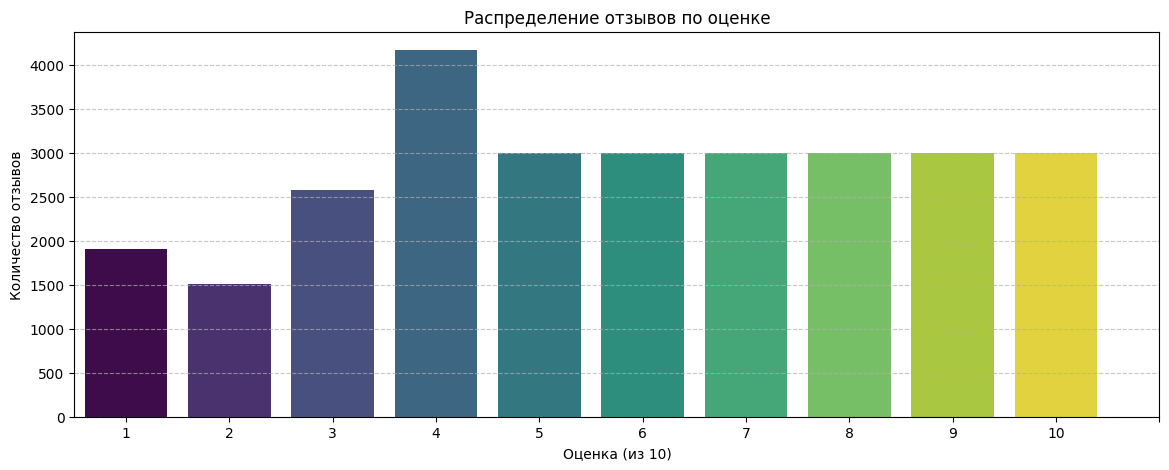

In [96]:
plt.figure(figsize=(14, 5))
sns.countplot(x=reviews_balanced['Score (out of 10)'], palette='viridis', hue=reviews_balanced['Score (out of 10)'], legend=False)
plt.title('Распределение отзывов по оценке')
plt.xlabel('Оценка (из 10)')
plt.ylabel('Количество отзывов')
plt.xticks(range(0, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [97]:
lang_stats = reviews_balanced.groupby('Language')['Score (out of 10)'].agg(['mean', 'median', 'std', 'count'])

lang_stats_filtered = lang_stats[lang_stats['count'] >= language_counts[top-1]]

display(lang_stats_filtered)

/var/folders/jm/7zgk4hp93jgb153vvqrrshrm0000gn/T/ipykernel_14953/270690786.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lang_stats_filtered = lang_stats[lang_stats['count'] >= language_counts[top-1]]


,mean,median,std,count
Language,,,,
bg,5.416667,5.0,2.795602,744
en,5.993258,6.0,2.634596,3263
es,6.432961,7.0,2.456839,716
it,5.775801,6.0,2.590174,562
mk,5.275820,5.0,2.775542,823
ru,5.817676,6.0,2.689020,19575
uk,5.829670,6.0,2.716247,910


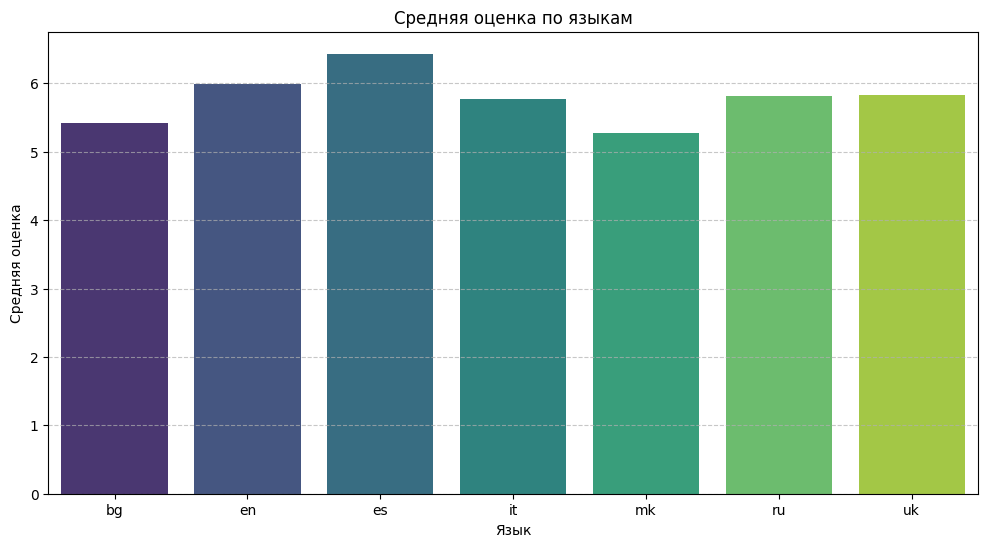

In [98]:
plt.figure(figsize=(12, 6))
sns.barplot(x=lang_stats_filtered.index, y=lang_stats_filtered['mean'], palette='viridis', hue=lang_stats_filtered.index, legend=False)
plt.xlabel('Язык')
plt.ylabel('Средняя оценка')
plt.title('Средняя оценка по языкам')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

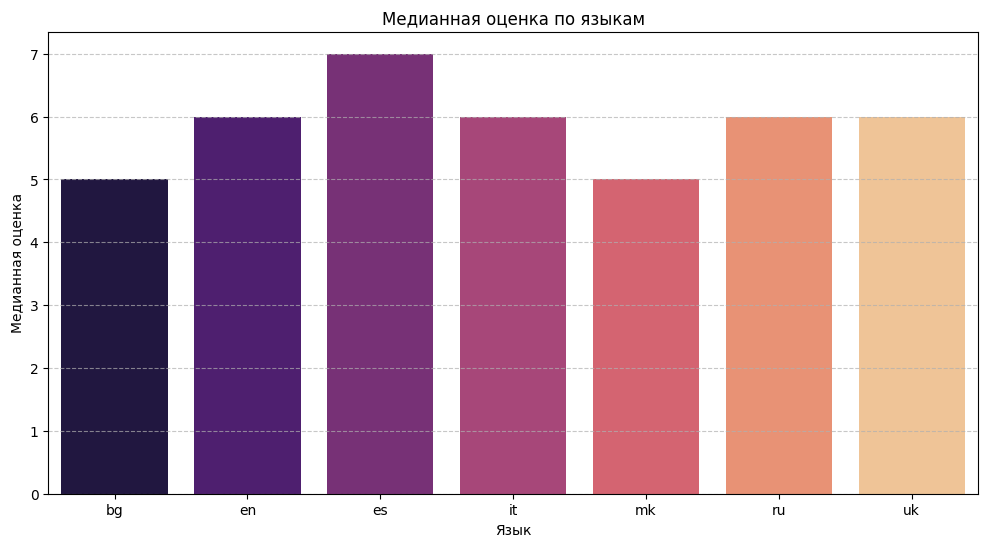

In [99]:
plt.figure(figsize=(12, 6))
sns.barplot(x=lang_stats_filtered.index, y=lang_stats_filtered['median'], palette='magma', hue=lang_stats_filtered.index, legend=False)
plt.xlabel('Язык')
plt.ylabel('Медианная оценка')
plt.title('Медианная оценка по языкам')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Было бы побольше разнообразия языков и оценок в выборке, ситуация была бы нагляднее, но из-за маленького количества отрицательных отзывов что-то сильно полезное отсюда не вытащить

Разве что — Испанцы, статистически, впечатлительнее

В одном из блоков кода сверху есть закомментированная версия инициализации `lang_stats_filtered` и это не просто так, если хратить в ней статы для всех языков, у которых есть хотя бы 100 отзывов, то можно увидеть достаточно похожую на реальность картиру (по крайней мере, мне как пользователю часто доводиться видеть такое) — много кто ставит 8 (даже не 9 и 10)